## Retrieve data from API

In [ ]:
import requests # to download data
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import scipy.stats

In [ ]:
cdc_df=[]
n_query_per_iter=1000
page_num=25
URL = "https://api.fda.gov/drug/event.json?sort=receivedate:desc"
for i in range(page_num):
  param={'skip': i*n_query_per_iter, 
          'limit': n_query_per_iter}
  response = requests.get(url=URL,params=param)

  if response.status_code == 200:
    cdc_df.extend(response.json()['results'])


In [ ]:
cdc_df=pd.DataFrame(cdc_df)

In [ ]:
cdc_df

,safetyreportversion,safetyreportid,primarysourcecountry,occurcountry,transmissiondateformat,transmissiondate,reporttype,serious,seriousnessdeath,seriousnesslifethreatening,...,receiptdate,fulfillexpeditecriteria,companynumb,duplicate,reportduplicate,primarysource,sender,receiver,patient,authoritynumb
0,1,21802403,CA,CA,102,20230113,1,1,2,2,...,20221231,1,CA-CELLTRION INC.-2020CA023093,1,"[{'duplicatesource': 'PFIZER INC', 'duplicaten...","{'reportercountry': 'CA', 'qualification': '3'}","{'sendertype': '2', 'senderorganization': 'FDA...","{'receivertype': '6', 'receiverorganization': ...",{'reaction': [{'reactionmeddraversionpt': '25....,NaN
1,1,21802404,JP,JP,102,20230112,1,1,2,2,...,20221231,1,JP-SAKK-01420912,NaN,NaN,"{'reportercountry': 'JP', 'qualification': '5'}","{'sendertype': '2', 'senderorganization': 'FDA...","{'receivertype': '6', 'receiverorganization': ...","{'patientsex': '2', 'reaction': [{'reactionmed...",NaN
2,1,21802405,US,US,102,20230113,2,2,2,2,...,20221231,2,US-ABBVIE-4219792,NaN,NaN,"{'reportercountry': 'US', 'qualification': '5'}","{'sendertype': '2', 'senderorganization': 'FDA...","{'receivertype': '6', 'receiverorganization': ...","{'patientsex': '2', 'reaction': [{'reactionmed...",NaN
3,1,21802407,TW,TW,102,20230113,1,1,2,2,...,20221231,2,TW-PFIZER INC-PV202200132356,1,"{'duplicatesource': 'PFIZER INC', 'duplicatenu...","{'reportercountry': 'TW', 'qualification': '3'}","{'sendertype': '2', 'senderorganization': 'FDA...","{'receivertype': '6', 'receiverorganization': ...","{'patientonsetage': '40', 'patientonsetageunit...",NaN
4,1,21802409,US,US,102,20230113,1,2,2,2,...,20221231,2,US-SA-SAC20221230000380,1,"[{'duplicatesource': 'SA', 'duplicatenumb': 'U...","{'reportercountry': 'US', 'qualification': '1'}","{'sendertype': '2', 'senderorganization': 'FDA...","{'receivertype': '6', 'receiverorganization': ...","{'patientsex': '1', 'reaction': [{'reactionmed...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1,21779158,US,US,102,20230112,2,2,2,2,...,20221226,2,US-ABBVIE-4209813,NaN,NaN,"{'reportercountry': 'US', 'qualification': '5'}","{'sendertype': '2', 'senderorganization': 'FDA...","{'receivertype': '6', 'receiverorganization': ...","{'patientsex': '2', 'reaction': [{'reactionmed...",NaN
24996,1,21779159,US,US,102,20230112,1,2,2,2,...,20221226,2,US-ABBVIE-4207219,NaN,NaN,"{'reportercountry': 'US', 'qualification': '5'}","{'sendertype': '2', 'senderorganization': 'FDA...","{'receivertype': '6', 'receiverorganization': ...","{'patientsex': '2', 'reaction': [{'reactionmed...",NaN
24997,1,21779160,US,US,102,20230113,1,2,2,2,...,20221226,2,US-SA-SAC20221222000516,1,"[{'duplicatesource': 'SA', 'duplicatenumb': 'U...","{'reportercountry': 'US', 'qualification': '1'}","{'sendertype': '2', 'senderorganization': 'FDA...","{'receivertype': '6', 'receiverorganization': ...","{'patientsex': '2', 'reaction': [{'reactionmed...",NaN
24998,1,21779161,US,US,102,20230113,2,2,2,2,...,20221226,2,US-AMGEN-USASL2022220261,1,"{'duplicatesource': 'AMGEN INC', 'duplicatenum...","{'reportercountry': 'US', 'qualification': '2'}","{'sendertype': '2', 'senderorganization': 'FDA...","{'receivertype': '6', 'receiverorganization': ...",{'reaction': [{'reactionmeddraversionpt': '25....,NaN


## Data Wrangling

In [ ]:

new=pd.json_normalize(cdc_df.patient,max_level=3)

In [ ]:
new["country"]=cdc_df.occurcountry
# 1 indicates adverse event
new["death"]=cdc_df.seriousnessdeath
new["disability"]=cdc_df.seriousnessdisabling
new["hospitalization"]=cdc_df.seriousnesshospitalization
new["lifethreatening"]=cdc_df.seriousnesslifethreatening
new['other']=cdc_df.seriousnessother

In [ ]:
new['med']=None

In [ ]:
df_tmp=pd.DataFrame(columns=['medicine'])
for i in range(len(new.drug)):
  lst=[]
  for row in new.drug[i]:
      if row['medicinalproduct'] not in lst:
        lst.append(row['medicinalproduct'])
  new['med'][i]=lst      
  #df_tmp.loc[i]=lst

In [ ]:
new['side_effects']=None
for i in range(len(new.reaction)):
  lst1=[]
  for row in new.reaction[i]:
      if row['reactionmeddrapt'] not in lst1:
        lst1.append(row['reactionmeddrapt'])
  new['side_effects'][i]=lst1

In [ ]:
new

In [ ]:
total_med=[]
for i in new.med:
  total_med=total_med+i



In [ ]:
top_ten_drugs=pd.Series(total_med).value_counts()[:10].index.to_list()
top_ten_drugs

['HUMIRA',
 'DUPIXENT',
 'INBRIJA',
 'NURTEC ODT',
 'SKYRIZI',
 'RINVOQ',
 'PREDNISONE',
 'RUBRACA',
 'PAXLOVID',
 'ASPIRIN']

In [ ]:
for d in top_ten_drugs:
  new[f'drug_{d}']=0
#for i in new.med:
new['other']=0

In [ ]:
new

,reaction,drug,summary.narrativeincludeclinical,patientsex,patientonsetage,patientonsetageunit,patientagegroup,patientweight,country,death,...,drug_HUMIRA,drug_DUPIXENT,drug_INBRIJA,drug_NURTEC ODT,drug_SKYRIZI,drug_RINVOQ,drug_PREDNISONE,drug_RUBRACA,drug_PAXLOVID,drug_ASPIRIN
0,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20200101,NaN,NaN,NaN,NaN,NaN,CA,2,...,0,0,0,0,0,0,1,0,0,0
1,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221201,2,NaN,NaN,NaN,NaN,JP,2,...,0,1,0,0,0,0,0,0,0,0
2,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,2,NaN,NaN,NaN,NaN,US,2,...,0,0,0,0,0,0,0,0,0,0
3,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221208,1,40,801,5,NaN,TW,2,...,0,0,0,0,0,0,0,0,0,0
4,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,1,NaN,NaN,NaN,NaN,US,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,2,NaN,NaN,NaN,NaN,US,2,...,1,0,0,0,0,0,0,0,0,0
24996,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,2,NaN,NaN,NaN,NaN,US,2,...,0,0,0,0,0,0,0,0,0,0
24997,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,2,NaN,NaN,NaN,NaN,US,2,...,0,1,0,0,0,0,0,0,0,0
24998,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,NaN,NaN,NaN,NaN,NaN,US,2,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for idx in range(len(new.med)):
  for i in new.med[idx]:
    if i not in top_ten_drugs:
      new['other'][idx]+=1
    else:
      new[f'drug_{i}'][idx]+=1

<ipython-input-216-78b8f76831ae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['other'][idx]+=1
<ipython-input-216-78b8f76831ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new[f'drug_{i}'][idx]+=1


In [ ]:
len(new.country.unique())

95

In [ ]:
new['serious_results']=cdc_df['serious']

ValueError: ignored

## EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.figure(figsize = (12, 6))
new.isna().sum().plot.bar();

In [ ]:
df_copy=new.copy()
df_copy =df_copy.drop(["patientweight", "patientagegroup", "patientonsetageunit"], axis = 1)

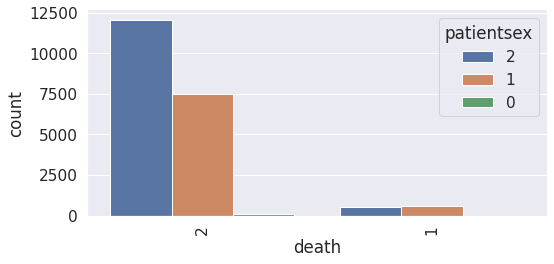

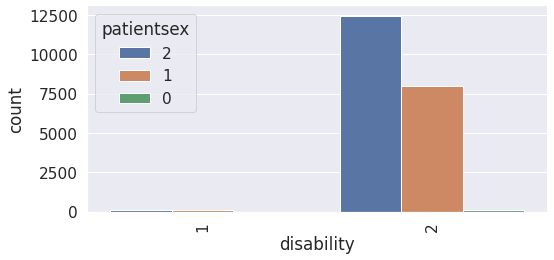

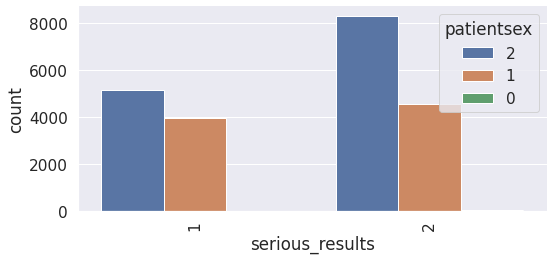

In [ ]:
c = ["death", "disability", "serious_results"]
sns.set(font_scale = 1.4)
for i, col_name in enumerate(c):
    sns.catplot(x = col_name, hue = 'patientsex', kind = 'count', data = df_copy, height = 4, aspect = 2, legend_out = False)
    plt.xticks(rotation = 90)
plt.show()


In [ ]:
import seaborn as sns
cor=new.corr()
# Generate a heatmap from the correlation matrix
sns.heatmap(cor, annot=True, cmap="coolwarm")

# Show the plot
plt.show()

,other,drug_HUMIRA,drug_DUPIXENT,drug_INBRIJA,drug_NURTEC ODT,drug_SKYRIZI,drug_RINVOQ,drug_PREDNISONE,drug_RUBRACA,drug_PAXLOVID,drug_ASPIRIN
other,1.000000,-0.159726,-0.051258,0.027610,-0.080962,-0.084920,-0.066621,0.270452,-0.036898,-0.028826,0.263240
drug_HUMIRA,-0.159726,1.000000,-0.086131,-0.085886,-0.081005,-0.073453,-0.062472,-0.011514,-0.062730,-0.060448,-0.051878
drug_DUPIXENT,-0.051258,-0.086131,1.000000,-0.044828,-0.042280,-0.039860,-0.033134,-0.009184,-0.032742,-0.029711,-0.006545
drug_INBRIJA,0.027610,-0.085886,-0.044828,1.000000,-0.041103,-0.039781,-0.034563,-0.029433,-0.031830,-0.031455,0.043066
drug_NURTEC ODT,-0.080962,-0.081005,-0.042280,-0.041103,1.000000,-0.037520,-0.032598,-0.025971,-0.030021,-0.028235,-0.026412
drug_SKYRIZI,-0.084920,-0.073453,-0.039860,-0.039781,-0.037520,1.000000,-0.030200,-0.024793,-0.029055,-0.028713,-0.025380
drug_RINVOQ,-0.066621,-0.062472,-0.033134,-0.034563,-0.032598,-0.030200,1.000000,0.003924,-0.023578,-0.023262,-0.021238
drug_PREDNISONE,0.270452,-0.011514,-0.009184,-0.029433,-0.025971,-0.024793,0.003924,1.000000,-0.019137,-0.017046,0.057502
drug_RUBRACA,-0.036898,-0.062730,-0.032742,-0.031830,-0.030021,-0.029055,-0.023578,-0.019137,1.000000,-0.022975,-0.009795
drug_PAXLOVID,-0.028826,-0.060448,-0.029711,-0.031455,-0.028235,-0.028713,-0.023262,-0.017046,-0.022975,1.000000,-0.003789


In [ ]:
cdc_df_new = cdc_df
patient = cdc_df_new['patient'].apply(pd.Series)

from pandas import json_normalize
reaction = patient['reaction'].apply(json_normalize)
drug = patient['drug'].apply(json_normalize)
summary = patient['summary'].apply(pd.Series)

patient = patient.drop(columns = ['reaction','drug','summary'])
patient = pd.concat([patient, reaction, drug, summary], axis=1)

cdc_df_new = cdc_df_new.drop(columns='patient')
cdc_df_new = pd.concat([cdc_df_new, patient], axis=1)
cdc_df_new.columns

Index([         'safetyreportversion',               'safetyreportid',
               'primarysourcecountry',                 'occurcountry',
             'transmissiondateformat',             'transmissiondate',
                         'reporttype',                      'serious',
                   'seriousnessdeath',   'seriousnesslifethreatening',
         'seriousnesshospitalization',         'seriousnessdisabling',
       'seriousnesscongenitalanomali',             'seriousnessother',
                  'receivedateformat',                  'receivedate',
                  'receiptdateformat',                  'receiptdate',
            'fulfillexpeditecriteria',                  'companynumb',
                          'duplicate',              'reportduplicate',
                      'primarysource',                       'sender',
                           'receiver',                'authoritynumb',
                         'patientsex',              'patientonsetage',
      

In [ ]:
cdc_df_new = cdc_df_new.drop(columns=0)

In [ ]:
def get_all_values(df,attribute, para):
  all_vals = []
  for i in range(len(df[attribute])):
    all_vals.append(df[attribute][i][para][0])
  return all_vals

def unique(list1):
    unique_list = [] 
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [ ]:
medicinal_products = get_all_values(cdc_df_new, 'drug','medicinalproduct')
unique_medicinal_products = unique(medicinal_products)
len(unique_medicinal_products) #1828

from collections import Counter

Counter(medicinal_products).keys()
count_of_each_product = Counter(medicinal_products).values()

**Number of Patients Dead**

In [ ]:
dead_patients_df = cdc_df_new.loc[cdc_df_new['seriousnessdeath']=='1']
dead_patients_df = dead_patients_df.reset_index(drop=True)
dead_patients_df

,safetyreportversion,safetyreportid,primarysourcecountry,occurcountry,transmissiondateformat,transmissiondate,reporttype,serious,seriousnessdeath,seriousnesslifethreatening,...,receiver,authoritynumb,patientsex,patientonsetage,patientonsetageunit,patientagegroup,patientweight,reaction,drug,narrativeincludeclinical
0,1,21802416,GB,GB,102,20230113,1,1,1,2,...,"{'receivertype': '6', 'receiverorganization': ...",NaN,1,57,801,5,NaN,reactionmeddraversionpt reactionm...,drugcharacterization medicinalproduct drugba...,NaN
1,1,21802425,IN,IN,102,20230113,2,1,1,2,...,"{'receivertype': '6', 'receiverorganization': ...",NaN,1,NaN,NaN,NaN,NaN,reactionmeddraversionpt reactionmeddrapt rea...,drugcharacterization medicinalproduct d...,NaN
2,1,21802514,US,US,102,20230113,1,1,1,2,...,"{'receivertype': '6', 'receiverorganization': ...",NaN,1,61,801,NaN,NaN,reactionmeddraversionpt reactionmeddrapt rea...,drugcharacterization medicinalproduct drugau...,CASE EVENT DATE: 20221223
3,1,21802525,KE,KE,102,20230113,1,1,1,2,...,"{'receivertype': '6', 'receiverorganization': ...",NaN,1,NaN,NaN,NaN,NaN,reactionmeddraversionpt reactionmeddrapt rea...,drugcharacterization medicinalproduct drugau...,NaN
4,1,21802542,FR,FR,102,20230113,1,1,1,NaN,...,"{'receivertype': '6', 'receiverorganization': ...",FR-AFSSAPS-RN20223025,1,60,801,5,NaN,reactionmeddraversionpt reactionmeddrapt rea...,drugcharacterization medicinalproduct drugba...,CASE EVENT DATE: 20221203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,1,21779016,CN,CN,102,20230113,2,1,1,2,...,"{'receivertype': '6', 'receiverorganization': ...",NaN,1,NaN,NaN,NaN,NaN,reactionmeddraversionpt reactionmeddrapt rea...,drugcharacterization medicinalproduct drugau...,NaN
1324,1,21779028,US,US,102,20230112,1,1,1,2,...,"{'receivertype': '6', 'receiverorganization': ...",NaN,NaN,NaN,NaN,NaN,NaN,reactionmeddraversionpt reactionmeddrapt rea...,drugcharacterization medicinalproduct drugau...,NaN
1325,1,21779068,IN,NaN,102,20230113,1,1,1,2,...,"{'receivertype': '6', 'receiverorganization': ...",NaN,NaN,NaN,NaN,NaN,NaN,reactionmeddraversionpt reactionmeddrapt rea...,drugcharacterization medicinalproduct drugau...,CASE EVENT DATE: 20221206
1326,1,21779070,JP,JP,102,20230112,1,1,1,2,...,"{'receivertype': '6', 'receiverorganization': ...",NaN,1,69,801,6,NaN,reactionmeddraversionpt reactionmeddrap...,drugcharacterization medicinalproduct drugau...,CASE EVENT DATE: 20190101


In [ ]:
medicinal_products_dead = get_all_values(dead_patients_df,'drug','medicinalproduct')
unique_medicinal_products_dead = unique(medicinal_products_dead)
len(unique_medicinal_products_dead)

def CountFrequency(my_list):     
    # Creating an empty dictionary
    freq = {}
    for items in my_list:
        freq[items] = my_list.count(items)
    return freq

In [ ]:
import operator
unique_medicinal_products_dead_freq = CountFrequency(medicinal_products_dead)
unique_medicinal_products_dead_freq

sorted_d = dict( sorted(unique_medicinal_products_dead_freq.items(), key=operator.itemgetter(1),reverse=True))
sorted_d

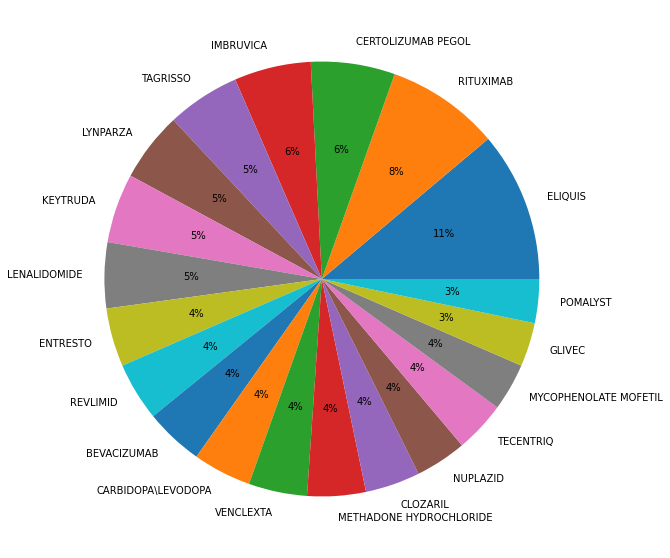

In [ ]:
first20pairs = {k: sorted_d[k] for k in list(sorted_d)[:20]}
colors = sns.color_palette('pastel')[0:20]
pie, ax = plt.subplots(figsize=[20,10])
#create pie chart
plt.pie(first20pairs.values(), labels = first20pairs.keys(), autopct='%.0f%%')
plt.title='Top 20 Products Contibuting to Deaths'
plt.show()

## data modelling


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
reg=new.dropna(subset=['patientonsetage','patientsex','serious_results'])
reg['patientonsetage']=reg['patientonsetage'].astype(int)

<ipython-input-253-09693948f1c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['patientonsetage']=reg['patientonsetage'].astype(int)


In [ ]:
reg['serious_results']=[1 if i=="1" else 0 for i in reg['serious_results']]

<ipython-input-257-1c72a1f5d909>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['serious_results']=[1 if i=="1" else 0 for i in reg['serious_results']]


In [ ]:
reg

,reaction,drug,summary.narrativeincludeclinical,patientsex,patientonsetage,patientonsetageunit,patientagegroup,patientweight,country,death,...,drug_INBRIJA,drug_NURTEC ODT,drug_SKYRIZI,drug_RINVOQ,drug_PREDNISONE,drug_RUBRACA,drug_PAXLOVID,drug_ASPIRIN,serious_results,serious_results1
3,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221208,1,40,801,5,NaN,TW,2,...,0,0,0,0,0,0,0,0,1,1
8,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,2,44,801,NaN,NaN,US,2,...,0,0,0,0,0,0,0,0,0,0
9,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,1,57,801,5,NaN,GB,1,...,0,0,0,0,0,0,0,0,1,1
10,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,1,73,801,NaN,NaN,FR,2,...,0,0,0,0,0,0,0,0,1,1
12,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221201,2,13,801,NaN,NaN,CL,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24986,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221202,2,101,801,6,NaN,US,2,...,0,0,0,0,0,0,0,0,0,0
24988,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,2,68,801,NaN,NaN,IT,2,...,0,0,0,0,0,0,0,0,1,1
24989,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20221201,1,68,801,NaN,NaN,CA,2,...,0,0,0,0,1,0,0,0,1,1
24990,"[{'reactionmeddraversionpt': '25.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20220701,2,49,801,NaN,NaN,DE,2,...,0,0,0,1,0,0,0,0,1,1


In [ ]:
X = reg[['patientonsetage', 'patientsex', 'drug_HUMIRA', 'drug_DUPIXENT', 'drug_INBRIJA','drug_NURTEC ODT','drug_SKYRIZI','drug_RINVOQ','drug_PREDNISONE','drug_RUBRACA','drug_PAXLOVID','drug_ASPIRIN']]
y = reg['serious_results']


In [ ]:
#train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.8)

In [ ]:
#predict the chance of getting serious side effects
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
prediction = logistic_regression.predict(X_test)
RMSE_on_test=np.mean((prediction - y_test)**2)**0.5


In [ ]:
RMSE_on_test

0.5075808462124863

In [ ]:
print("Coefficients: ", logistic_regression.coef_)
print("Intercept: ", logistic_regression.intercept_)

Coefficients:  [[-4.28788328e-07 -3.48058855e-01 -2.37797615e+00 -2.71261103e+00
  -3.84189582e+00 -3.64887637e+00 -2.50148110e+00 -1.87338383e+00
   1.66285947e+00 -1.90063588e+00 -2.29239164e+00  7.96437173e-01]]
Intercept:  [1.24627801]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1)

Accuracy:  0.7423616845582164
Precision:  0.699349945828819
Recall:  0.9492647058823529
F1 score:  0.8053649407361197


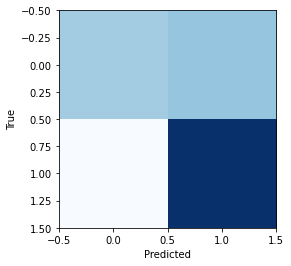

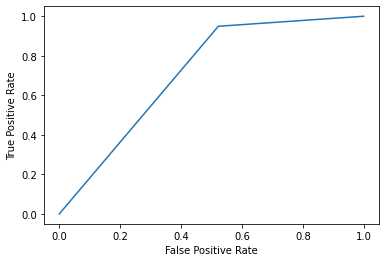

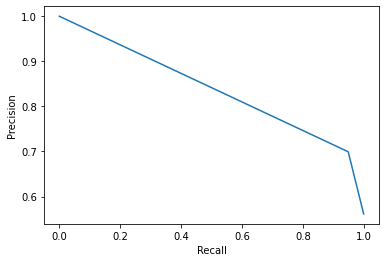

In [ ]:
#model evaluation

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Plot the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Plot the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
#decision tree regresssion
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = regressor.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.19883166706942468
R-squared: 0.1924481687650389


In [ ]:
from sklearn.tree import export_graphviz


# Visualize the decision tree
export_graphviz(regressor, out_file='tree.dot', 
                                feature_names=['patientonsetage', 'patientsex', 'drug_HUMIRA', 'drug_DUPIXENT', 'drug_INBRIJA','drug_NURTEC ODT','drug_SKYRIZI','drug_RINVOQ','drug_PREDNISONE','drug_RUBRACA','drug_PAXLOVID','drug_ASPIRIN'],  
                                filled=True, rounded=True,  
                                special_characters=True)  
